In [12]:
import numpy as np 
import pandas as pd 
import os, glob, pickle, json
import matplotlib.pyplot as plt 
from decord import VideoReader, cpu
from pupil_apriltags import Detector
import cv2, re

In [6]:
class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        # Handle unknown classes dynamically
        if module == "__main__" and name in ["Config", "Data"]:
            # Define a placeholder class for unknown classes
            class Placeholder:
                def __init__(self, *args, **kwargs):
                    pass
                
                def __repr__(self):
                    return f"<{name}Placeholder (original class not defined)>"
            
            return Placeholder
        
        # Fall back to the default behavior for known classes
        return super().find_class(module, name)

# Load the pickle file using the custom unpickler
with open("./data/jiwon_241218_1.pkl", "rb") as f:
    data = CustomUnpickler(f).load()

# Inspect the loaded data
print(len(data['data'].eye_pos))

64


In [2]:
data_dir = 'jiwon_eyes/2024-12-1814-24-22-98722b4d'
gaze = pd.read_csv(data_dir + '/gaze.csv')
blinks = pd.read_csv(data_dir + '/blinks.csv')
events = pd.read_csv(data_dir + '/events.csv')

# remove blinks from gaze data 
gaze_clean = gaze
for b in range(len(blinks)):
    gaze_clean = gaze_clean[~((gaze_clean['timestamp [ns]'] >= blinks['start timestamp [ns]'][b]) & 
                               (gaze_clean['timestamp [ns]'] < blinks['end timestamp [ns]'][b]))]
print(f'Number of blinks cleaned: {len(blinks)} ')

events = pd.read_csv(data_dir + '/events.csv')
world_times = pd.read_csv(data_dir + '/world_timestamps.csv')

Number of blinks cleaned: 150 


In [3]:
# load the marker points
with open(data_dir + '/marker_points.json', 'r') as f:
    marker_points = json.load(f)
    
marker_points = np.array(marker_points)
avg_marker_points = np.mean(marker_points, axis=0)
print(avg_marker_points)

[[ 376.6  218.2]
 [1378.4  198.2]
 [ 442.6  720.4]
 [1338.2  705. ]]


In [4]:
def frame_chop(frame, markers):
    min_x = int(np.min(markers[:, 0]))
    max_x = int(np.max(markers[:, 0]))
    min_y = int(np.min(markers[:, 1]))
    max_y = int(np.max(markers[:, 1]))
    
    frame_chopped = frame[min_y:max_y, min_x:max_x]
    return frame_chopped


In [21]:
def detect_dot(frame, avg_marker_points):
    # find center
    center = [int(np.max(avg_marker_points[:,0])-np.min(avg_marker_points[:,0]))/2,
                int(np.max(avg_marker_points[:,1])-np.min(avg_marker_points[:,1]))/2]
    
    # copy image    
    frame_c = frame.copy()
    frame_chopped = frame_chop(frame_c, avg_marker_points)

    # filter image
    lower = np.array([200, 200, 200])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(frame_chopped, lower, upper)
    frame_filtered = cv2.bitwise_and(frame_chopped, frame_chopped, mask=mask)
    frame_gray = cv2.cvtColor(frame_filtered, cv2.COLOR_BGR2GRAY)
    frame_binary = cv2.threshold(frame_gray, 200, 255, cv2.THRESH_BINARY)[1]
    
    # detect blob
    params = cv2.SimpleBlobDetector_Params()
    params.filterByColor = True
    params.blobColor = 255
    params.filterByArea = True
    params.minArea = 5
    params.maxArea = 200
    
    detector = cv2.SimpleBlobDetector_create(params)
    dots = detector.detect(frame_binary)
    
    if len(dots) > 0:
        for d in range(len(dots)):
            # remove dots that are close to the center
            if np.linalg.norm(np.array(dots[d].pt) - np.array(center)) < 10:
                dots.pop(d)
        
        if len(dots) > 0:   # if still the dots are more than one point, take the one farther from the rim
            dist = []
            for d in range(len(dots)):
                dist.append(np.linalg.norm(np.array(dots[d].pt) - np.array(center)))
            dot = dots[np.argmax(dist)]
            dot = np.array([dot.pt[0] + np.min(avg_marker_points[:,0]), dot.pt[1] + np.min(avg_marker_points[:,1])])        
    else:
        dot = None
    
    return dot
        

In [25]:
def px_to_dva(data_dir, x_px, y_px):
    # load camera intrinsics 
    camera_matrix = np.array(json.load(open(data_dir + '/scene_camera.json'))['camera_matrix'])
    distortion_coeffs = np.array(json.load(open(data_dir + '/scene_camera.json'))['distortion_coefficients'])
    
    pixel_coords = np.array([x_px, y_px], dtype=np.float32)

    # First, we need to undistort the points
    undistorted_point = cv2.undistortPoints(pixel_coords.reshape(1, 1, 2), camera_matrix, distortion_coeffs, P=camera_matrix)

    # Convert to normalized homogeneous coordinates
    norm_point = np.append(undistorted_point, 1)

    # transform to camera coordinates
    img_to_cam = np.linalg.inv(camera_matrix)
    cam_coords = np.dot(img_to_cam, norm_point)

    # Calculate elevation and azimuth based on the camera coordinates
    elevation = np.rad2deg(np.arctan2(-cam_coords[1], cam_coords[2]))
    azimuth = np.rad2deg(np.arctan2(cam_coords[0], cam_coords[2]))

    return azimuth, elevation
    

In [34]:
# for all frames, try to find the marker points - starting from the first trial to the last
nEvents = int(re.search(r'trial (\d+), end', events['name'].iloc[-2]).group(1))
target_locations = events[events['name'].str.contains(', target location')]['name'] \
    .apply(lambda x: x.split(':')[1].replace(')', '').replace('(', '').strip())
unique_targets = sorted(target_locations.unique())
target_ids = target_locations.map({target: idx+1 for idx, target in enumerate(unique_targets)}).values

video_file = glob.glob(data_dir + '/*.mp4')[0]
video = VideoReader(video_file, ctx=cpu(0))

df = pd.DataFrame(columns=['trial', 'target id', 'frame', 'timestamp [ns]', 'dot x [px]', 'dot y [px]',
                           'azimuth [deg]', 'elevation [deg]'])
for e in range(1,nEvents+1):
    print(f'Processing trial number {e}')
    start_time = events[events['name'].str.contains(f'trial {e}, target location')]['timestamp [ns]'].values[0]
    end_time = events[events['name'].str.contains(f'trial {e}, end')]['timestamp [ns]'].values[0]

    frames = world_times[(world_times['timestamp [ns]'] >= start_time) & (world_times['timestamp [ns]'] <= end_time)].index
    for f in range(len(frames)):
        frame = video[frames[f]].asnumpy()
        dots = detect_dot(frame, avg_marker_points)
        
        if dots is not None:
            azimuth, elevation = px_to_dva(data_dir, dots[0], dots[1])
        else:
            azimuth, elevation = None, None
        
        new_row = pd.DataFrame({
            'trial': e,
            'target id': target_ids[e-1],
            'frame': frames[f],
            'timestamp [ns]': world_times['timestamp [ns]'][frames[f]],
            'dot x [px]': dots[0] if dots is not None else None,
            'dot y [px]': dots[1] if dots is not None else None,
            'azimuth [deg]': azimuth,
            'elevation [deg]': elevation
        }, index=[0])
        
        # add new row to df
        df = pd.concat([df, new_row], ignore_index=True)

# save to csv file 
df.to_csv(data_dir + '/dots.csv', index=False)


Processing trial number 1
Processing trial number 2
Processing trial number 3
Processing trial number 4
Processing trial number 5
Processing trial number 6
Processing trial number 7
Processing trial number 8
Processing trial number 9
Processing trial number 10
Processing trial number 11
Processing trial number 12
Processing trial number 13
Processing trial number 14
Processing trial number 15
Processing trial number 16
Processing trial number 17
Processing trial number 18
Processing trial number 19
Processing trial number 20
Processing trial number 21
Processing trial number 22
Processing trial number 23
Processing trial number 24
Processing trial number 25
Processing trial number 26
Processing trial number 27
Processing trial number 28
Processing trial number 29
Processing trial number 30
Processing trial number 31
Processing trial number 32
Processing trial number 33
Processing trial number 34
Processing trial number 35
Processing trial number 36
Processing trial number 37
Processing

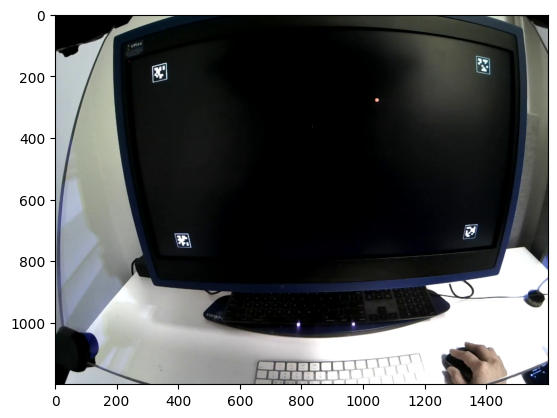

In [42]:
plt.imshow(frame)


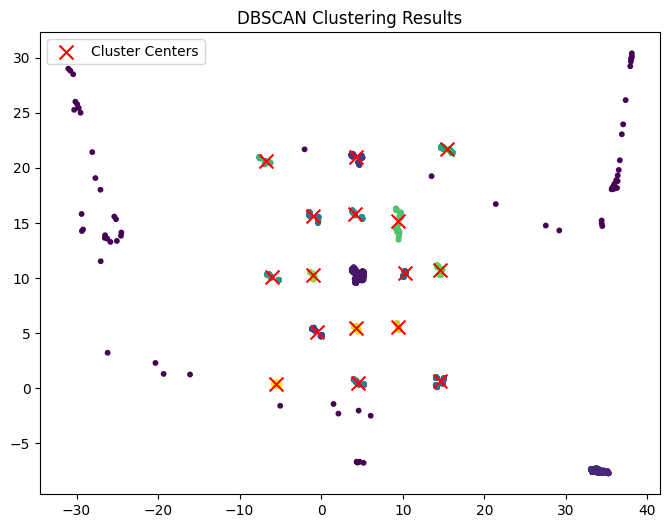

In [105]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

dots = pd.read_csv(data_dir + '/dots.csv')
dots.dropna(inplace=True)
data = dots[['azimuth [deg]', 'elevation [deg]']].values

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

dbscan = DBSCAN(eps=0.1, min_samples=30)
clusters = dbscan.fit_predict(data_scaled)

# Get cluster centers (true positive positions)
unique_clusters = np.unique(clusters[clusters != -1])  # Exclude noise points (-1)

# make a data frame using the unique clusters 
# iterate unique clusters
cluster_df = pd.DataFrame(columns = ['cluster id', 'x [deg]', 'y [deg]', 'x [px]', 'y [px]'])
for c in unique_clusters:
    row = [{'cluster id': c, 
            # 'target id': np.bincount(dots['target id'][clusters == c].values[0]).argmax(),
            'x [deg]': data[clusters == c][:, 0].mean(),
            'y [deg]': data[clusters == c][:, 1].mean(),
            'x [px]': dots['dot x [px]'][clusters == c].mean(),
            'y [px]': dots['dot y [px]'][clusters == c].mean()}]
    # append row to cluster_df
    cluster_df = pd.concat([cluster_df, pd.DataFrame(row)], ignore_index=True)

# from true_positive_positions, remove the closest to the center, and remain 16 points that are closest to the center
center = cluster_df[['x [deg]', 'y [deg]']].mean().values
dist = [np.linalg.norm(pos - center) for pos in cluster_df[['x [deg]', 'y [deg]']].values]
cluster_df['dist_center'] = dist
cluster_df = cluster_df.drop(cluster_df['dist_center'].idxmax())
cluster_df = cluster_df.drop(cluster_df['dist_center'].idxmin())

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', s=10)
plt.scatter(
    [pos for pos in cluster_df['x [deg]'].values], 
    [pos for pos in cluster_df['y [deg]'].values], 
    color='red', label='Cluster Centers', marker='x', s=100
)
plt.title("DBSCAN Clustering Results")
plt.legend()
plt.show()


In [ ]:
targets_on_screen = events[events['name'].str.contains(', target location')]['name']

# get trial_and_target locations 
target_locations_df = pd.DataFrame(columns=['trial', 'target x [px]', 'target y [px]'])
for t in targets_on_screen:
    row = [{'trial': int(re.search(r'trial (\d+)', t).group(1)),
            'target x [px]': float(re.search(r'(-?\d+\.?\d*), (-?\d+\.?\d*)', t).group(1)),
            'target y [px]': float(re.search(r'(-?\d+\.?\d*), (-?\d+\.?\d*)', t).group(2))}]
    target_locations_df = pd.concat([target_locations_df, pd.DataFrame(row)], ignore_index=True)

# get unique target cooridinates
unique_target_coords = target_locations_df[['target x [px]', 'target y [px]']].drop_duplicates()

# sort the unique_target_coords
unique_target_coords = unique_target_coords.sort_values(by=['target x [px]', 'target y [px]']).reset_index(drop=True)

# map the target ids to the taget locations
target_locations_df['target id'] = target_locations_df.apply(lambda x: unique_target_coords[
    (unique_target_coords['target x [px]'] == x['target x [px]']) & 
    (unique_target_coords['target y [px]'] == x['target y [px]'])].index[0]+1, axis=1)


    target x [px]  target y [px]
0           -10.0          -10.0
1           -10.0            0.0
2           -10.0           10.0
3            -5.0           -5.0
4            -5.0            0.0
5            -5.0            5.0
6             0.0          -10.0
7             0.0           -5.0
8             0.0            5.0
9             0.0           10.0
10            5.0           -5.0
11            5.0            0.0
12            5.0            5.0
13           10.0          -10.0
14           10.0            0.0
15           10.0           10.0
   trial  target x [px]  target y [px]  target id
0      1            0.0           10.0         10
1      2           -5.0           -5.0          4
2      3           -5.0           -5.0          4
3      4            5.0            0.0         12
4      5            5.0            0.0         12
..   ...            ...            ...        ...
59    60            0.0            5.0          9
60    61           10.0           10.0 

[[0.         0.        ]
 [0.03735934 0.00670304]
 [0.05746603 0.01389302]
 [0.25871827 0.22051555]
 [0.25882851 0.23944404]
 [0.28494901 0.24297433]
 [0.4956891  0.45621941]
 [0.49756917 0.4652083 ]
 [0.49988473 0.47190834]
 [0.5110813  0.48532208]
 [0.73284537 0.69363842]
 [0.73341111 0.71752264]
 [0.76849688 0.72623244]
 [0.96161878 0.94869382]
 [0.96561339 0.96879207]
 [1.         1.        ]]


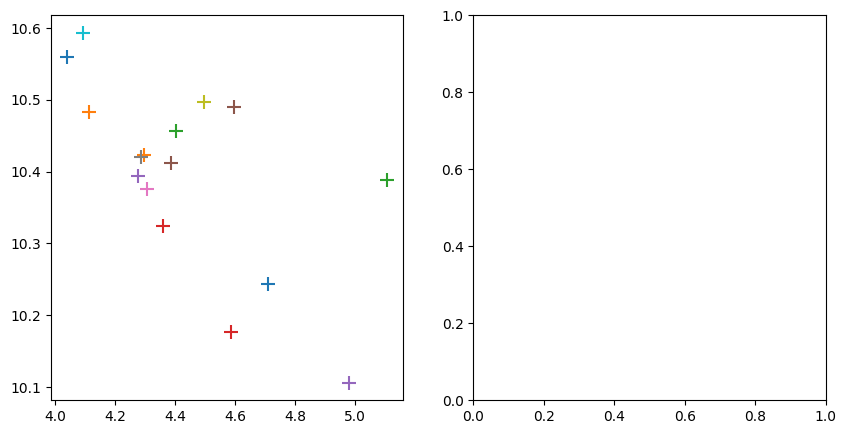

In [38]:
df = pd.read_csv(os.path.join(data_dir, 'gaze_vs_dot.csv'))

# get the median target positions within the same target id 
median_target = df.groupby('target id')[['target x [deg]', 'target y [deg]']].median()

# in the first figure, plot the raw data with targets
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for t in range(len(median_target)):
    target = median_target.iloc[t]
    ax[0].scatter(target['target x [deg]'], target['target y [deg]'], marker='+', s=100)


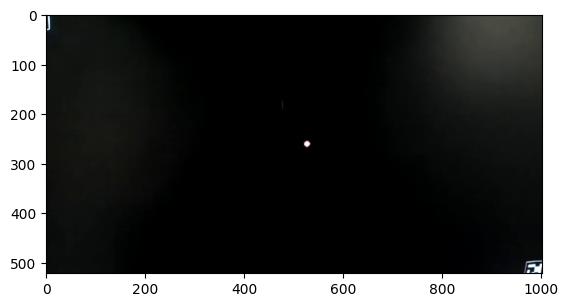

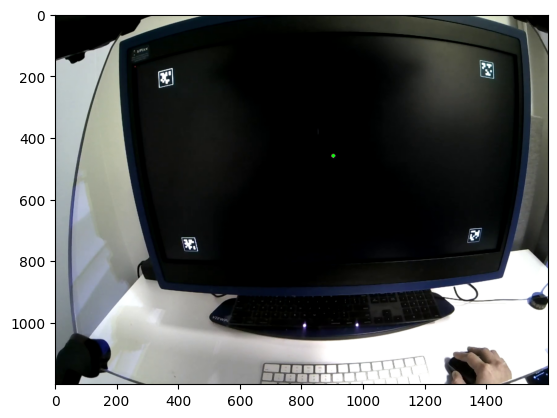

In [54]:
frame_num = 500
video = VideoReader(glob.glob(data_dir + '/*.mp4')[0], ctx=cpu(0))
frame = video[frame_num].asnumpy()
frame_chopped = frame_chop(frame, avg_marker_points)
frame_gray = cv2.cvtColor(frame_chopped, cv2.COLOR_BGR2GRAY)
# frame_binary = cv2.threshold(frame_gray, 250, 255, cv2.THRESH_BINARY_INV)[1]
# frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame_bitwise = cv2.bitwise_not(frame_gray)
# frame_bitwise = cv2.bitwise_not(frame_binary)
plt.imshow(frame_chopped, cmap='gray')
plt.show()

params = cv2.SimpleBlobDetector_Params()
params.filterByColor = True
params.blobColor = 0
params.filterByArea = True
params.filterByCircularity = True
params.minCircularity = .3
params.minArea = 15
params.maxArea = 200
detector = cv2.SimpleBlobDetector_create(params)
dots = detector.detect(frame_bitwise)
for d in dots:
    x, y = d.pt
    x, y = x + np.min(avg_marker_points[:, 0]), y + np.min(avg_marker_points[:, 1])
    cv2.circle(frame, (int(x), int(y)), 5, (0, 255, 0), -1)
plt.imshow(frame)
# print(dots)

In [12]:
print(gaze_clean.keys())
print(events.keys())

Index(['section id', 'recording id', 'timestamp [ns]', 'gaze x [px]',
       'gaze y [px]', 'worn', 'fixation id', 'blink id', 'azimuth [deg]',
       'elevation [deg]'],
      dtype='object')
Index(['recording id', 'timestamp [ns]', 'name', 'type'], dtype='object')


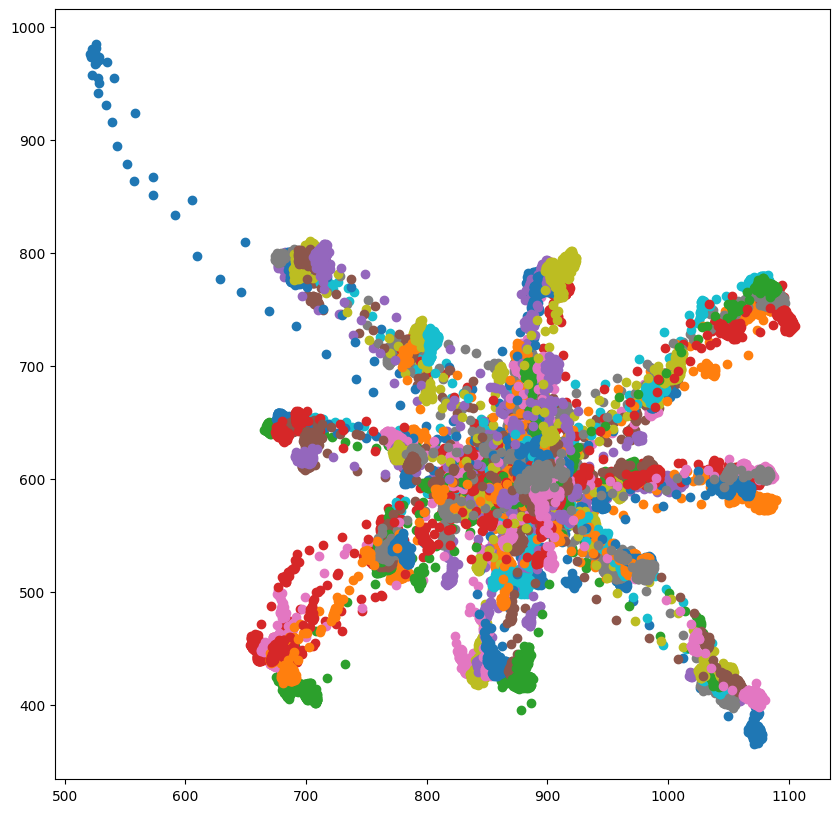

In [15]:
# draw each event's gaze trajectory 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for e in range(1,len(events)-1):
    gaze_event = gaze_clean[(gaze_clean['timestamp [ns]'] >= events['timestamp [ns]'][e]) & 
                            (gaze_clean['timestamp [ns]'] < events['timestamp [ns]'][e+1])]
    ax.plot(gaze_event['gaze x [px]'], gaze_event['gaze y [px]'], 'o')

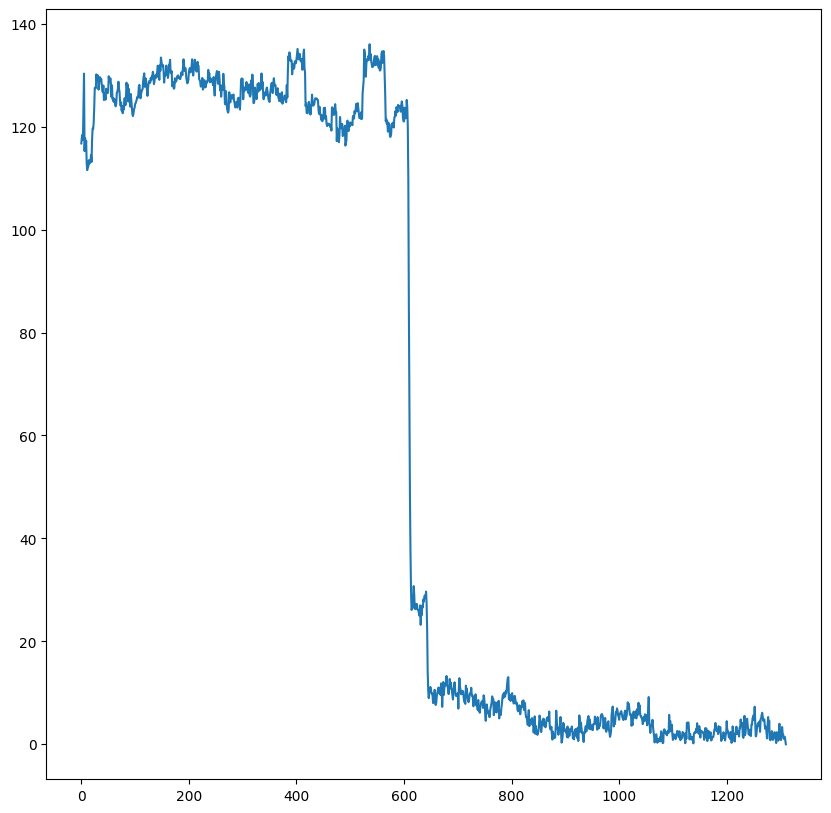

In [20]:
# draw one of the event's gaze against to the final landing position
fig, ax = plt.subplots(1,1,figsize=(10,10))
pos = gaze_event[['gaze x [px]', 'gaze y [px]']].values
distance = np.linalg.norm(pos - pos[-1], axis=1)
ax.plot(distance)
# ax.set_ylim([0,5])
